In [ ]:
!pip install rouge-score nltk

In [ ]:
!pip install -U bitsandbytes
# !pip install accelerate bitsandbytes
# !pip install bitsandbytes-cuda110 bitsandbytes

In [ ]:
!pip install seaborn
!pip install pandas
!pip install matplotlib
!pip install time

In [5]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from accelerate import init_empty_weights
import gc
import psutil
import numpy as np
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time  # Added missing import
from typing import Dict, List, Tuple

# Evaluating DistilGPT2

Loading distilgpt2-medical...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Successfully loaded distilgpt2-medical

Starting evaluation...

=== distilgpt2-medical Output for Case 1 ===

Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
           Animate history (see below) is a physical examination that has been performed to confirm or estimate any symptoms associated from an individual's initial exposure during use in this area prior on their own so as not to cause further risk for future exposures later than before.[1] A person can be diagnosed by using inhalation equipment such Asperger’s Breathalyzer if there have ever bee

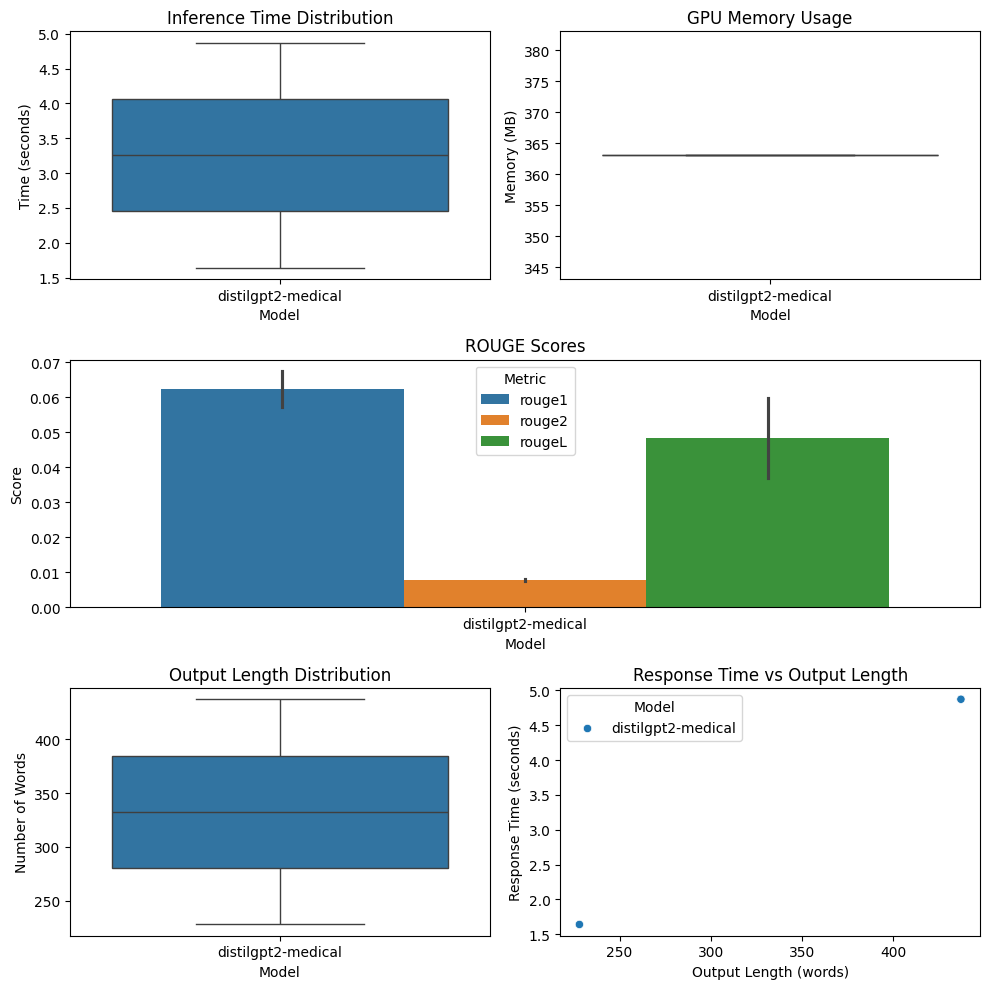

In [10]:
class ModelLoader:
    def __init__(self):
        self.models = {}
        self.quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

    def load_models(self):
        model_configs = {
            'distilgpt2-medical': {
                'path': "Apurva3509/distilgpt2-medical-finetuned",
                'use_4bit': False
            }
        }

        for model_name, config in model_configs.items():
            try:
                print(f"Loading {model_name}...")

                gc.collect()
                torch.cuda.empty_cache()

                if config['use_4bit']:
                    model = AutoModelForCausalLM.from_pretrained(
                        config['path'],
                        quantization_config=self.quantization_config,
                        device_map="auto",
                        torch_dtype=torch.float16
                    )
                else:
                    model = AutoModelForCausalLM.from_pretrained(
                        config['path'],
                        torch_dtype=torch.float16
                    ).to('cuda')

                tokenizer = AutoTokenizer.from_pretrained(config['path'])

                if tokenizer.pad_token is None:
                    tokenizer.pad_token = tokenizer.eos_token

                self.models[model_name] = (model, tokenizer)
                print(f"Successfully loaded {model_name}")

            except Exception as e:
                print(f"Error loading {model_name}: {str(e)}")

        return self.models

class ModelEvaluator:
    def __init__(self, models):
        self.models = models
        self.scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def evaluate_model(self, model_name, model, tokenizer, input_text, max_length=512):
        try:
            inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

            stopping_criteria = tokenizer.eos_token_id if tokenizer.eos_token_id is not None else tokenizer.pad_token_id

            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.95,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=stopping_criteria,
                    eos_token_id=stopping_criteria,
                    min_length=100,
                    num_return_sequences=1
                )
            inference_time = time.time() - start_time

            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

            input_text = input_text.strip()
            if output_text.startswith(input_text):
                output_text = output_text[len(input_text):].strip()

            gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

            return {
                'output': output_text,
                'inference_time': inference_time,
                'gpu_memory': gpu_memory
            }

        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None

    def evaluate_all_models(self, test_cases, reference_answers):
        results = {
            'performance': [],
            'memory': [],
            'quality': [],
            'outputs': []
        }

        for model_name, (model, tokenizer) in self.models.items():
            for i, test_case in enumerate(test_cases):
                eval_result = self.evaluate_model(model_name, model, tokenizer, test_case)

                if eval_result:
                    results['outputs'].append({
                        'model': model_name,
                        'case': i+1,
                        'input': test_case,
                        'output': eval_result['output'],
                        'reference': reference_answers[i] if i < len(reference_answers) else None
                    })

                    if i < len(reference_answers):
                        scores = self.scorer.score(reference_answers[i], eval_result['output'])

                        results['performance'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'Time': eval_result['inference_time']
                        })

                        results['memory'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'Memory': eval_result['gpu_memory']
                        })

                        results['quality'].append({
                            'Model': model_name,
                            'Case': i+1,
                            'rouge1': scores['rouge1'].fmeasure,
                            'rouge2': scores['rouge2'].fmeasure,
                            'rougeL': scores['rougeL'].fmeasure
                        })

                        print(f"\n=== {model_name} Output for Case {i+1} ===")
                        print("\nInput:")
                        print(test_case.strip())
                        print("\nGenerated Output:")
                        print(eval_result['output'])
                        print("\nReference Answer:")
                        print(reference_answers[i])
                        print(f"\nMetrics:")
                        print(f"Inference Time: {eval_result['inference_time']:.2f}s")
                        print(f"GPU Memory: {eval_result['gpu_memory']:.1f}MB")
                        print(f"ROUGE-1: {scores['rouge1'].fmeasure:.3f}")
                        print(f"ROUGE-2: {scores['rouge2'].fmeasure:.3f}")
                        print(f"ROUGE-L: {scores['rougeL'].fmeasure:.3f}")
                        print("-" * 80)

        return results

def analyze_outputs(results):
    output_analysis = {}

    for output in results['outputs']:
        model_name = output['model']
        if model_name not in output_analysis:
            output_analysis[model_name] = {
                'avg_length': [],
                'response_times': [],
                'rouge_scores': []
            }

        output_analysis[model_name]['avg_length'].append(len(output['output'].split()))

        perf_data = next(p for p in results['performance']
                        if p['Model'] == model_name and p['Case'] == output['case'])
        output_analysis[model_name]['response_times'].append(perf_data['Time'])

        quality_data = next(q for q in results['quality']
                          if q['Model'] == model_name and q['Case'] == output['case'])
        output_analysis[model_name]['rouge_scores'].append(quality_data['rouge1'])

    print("\n=== Output Analysis ===")
    for model_name, analysis in output_analysis.items():
        print(f"\n{model_name}:")
        print(f"Average output length: {np.mean(analysis['avg_length']):.1f} words")
        print(f"Average response time: {np.mean(analysis['response_times']):.2f}s")
        print(f"Average ROUGE-1 score: {np.mean(analysis['rouge_scores']):.3f}")
        print(f"Response time range: {min(analysis['response_times']):.2f}s - {max(analysis['response_times']):.2f}s")

    return output_analysis

def plot_results(results, output_analysis):
    fig = plt.figure(figsize=(10, 10))
    gs = fig.add_gridspec(3, 2)

    # Performance Plot
    ax1 = fig.add_subplot(gs[0, 0])
    perf_df = pd.DataFrame(results['performance'])
    sns.boxplot(data=perf_df, x='Model', y='Time', ax=ax1)
    ax1.set_title('Inference Time Distribution')
    ax1.set_ylabel('Time (seconds)')

    # Memory Plot
    ax2 = fig.add_subplot(gs[0, 1])
    mem_df = pd.DataFrame(results['memory'])
    sns.boxplot(data=mem_df, x='Model', y='Memory', ax=ax2)
    ax2.set_title('GPU Memory Usage')
    ax2.set_ylabel('Memory (MB)')

    # Quality Metrics Plot
    ax3 = fig.add_subplot(gs[1, :])
    quality_df = pd.DataFrame(results['quality'])
    quality_melted = pd.melt(quality_df,
                            id_vars=['Model', 'Case'],
                            value_vars=['rouge1', 'rouge2', 'rougeL'],
                            var_name='Metric',
                            value_name='Score')
    sns.barplot(data=quality_melted, x='Model', y='Score', hue='Metric', ax=ax3)
    ax3.set_title('ROUGE Scores')

    # Output Length Distribution
    ax4 = fig.add_subplot(gs[2, 0])
    length_data = []
    for model_name, analysis in output_analysis.items():
        for length in analysis['avg_length']:
            length_data.append({'Model': model_name, 'Length': length})
    length_df = pd.DataFrame(length_data)
    sns.boxplot(data=length_df, x='Model', y='Length', ax=ax4)
    ax4.set_title('Output Length Distribution')
    ax4.set_ylabel('Number of Words')

    # Response Time vs Output Length
    ax5 = fig.add_subplot(gs[2, 1])
    time_length_data = []
    for model_name, analysis in output_analysis.items():
        for time, length in zip(analysis['response_times'], analysis['avg_length']):
            time_length_data.append({
                'Model': model_name,
                'Time': time,
                'Length': length
            })
    time_length_df = pd.DataFrame(time_length_data)
    sns.scatterplot(data=time_length_df, x='Length', y='Time', hue='Model', ax=ax5)
    ax5.set_title('Response Time vs Output Length')
    ax5.set_xlabel('Output Length (words)')
    ax5.set_ylabel('Response Time (seconds)')

    plt.tight_layout()
    plt.show()

def main():
    test_cases = [
        """
        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        """,
        """
        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
        """
    ]

    reference_answers = [
        """
        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        """,
        """
        Differential diagnosis includes:
        1. Pulmonary Embolism
        2. Pneumothorax
        3. Pleurisy
        4. Acute Coronary Syndrome

        Immediate workup needed:
        1. D-dimer
        2. Chest X-ray
        3. ECG
        4. Cardiac enzymes
        """
    ]

    try:
        loader = ModelLoader()
        models = loader.load_models()

        if not models:
            print("No models were successfully loaded")
            return

        evaluator = ModelEvaluator(models)

        print("\nStarting evaluation...")
        results = evaluator.evaluate_all_models(test_cases, reference_answers)

        output_analysis = analyze_outputs(results)
        plot_results(results, output_analysis)

    except Exception as e:
        print(f"Evaluation failed: {str(e)}")
        raise

if __name__ == "__main__":
    main()

# Evaluating all 3 Models

In [21]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import time
import numpy as np
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc

Starting model evaluation...

Loading distilgpt2-medical...


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Successfully loaded distilgpt2-medical

=== distilgpt2-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
           Viewing this page is not a complete list unless you have read these items carefully or in detail before starting any medical procedure on your own to prevent it from becoming an emergency condition that will result if they become serious enough for someone else (if there's no indication). The symptoms may be severe but rarely experienced because their illness has been treated without incident by other healthca

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.10/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


Successfully loaded llama-medical

=== llama-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
         Answered by Dr.Laxman Aryal on February-27th -2015

Patient has symptoms which can be related to Tuberculosis (TB), Lung cancer or Chronic Obstructive Pulmonary Disease(COPD). 

The patient is at risk for TB due to his history as a smoker.

There should not have any chest radiography done before bronchoscopy in patients who may need further evaluation because their clinical condition requires it eg; those that develop res

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.



Loading gemma-medical...
Successfully loaded gemma-medical

=== gemma-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
t', 'The provided term does not correspond any known disease.')) }}  model The differential diagnosis includes lung cancer or tuberculosis.


Model A chest x ray may show an enlarged mediastinum as well if there was significant involvement in either primary lesion within it (e g solitary metastasis). On CT scan multiple nodules can be seen throughout both lungs which typically have irregular borders on ul

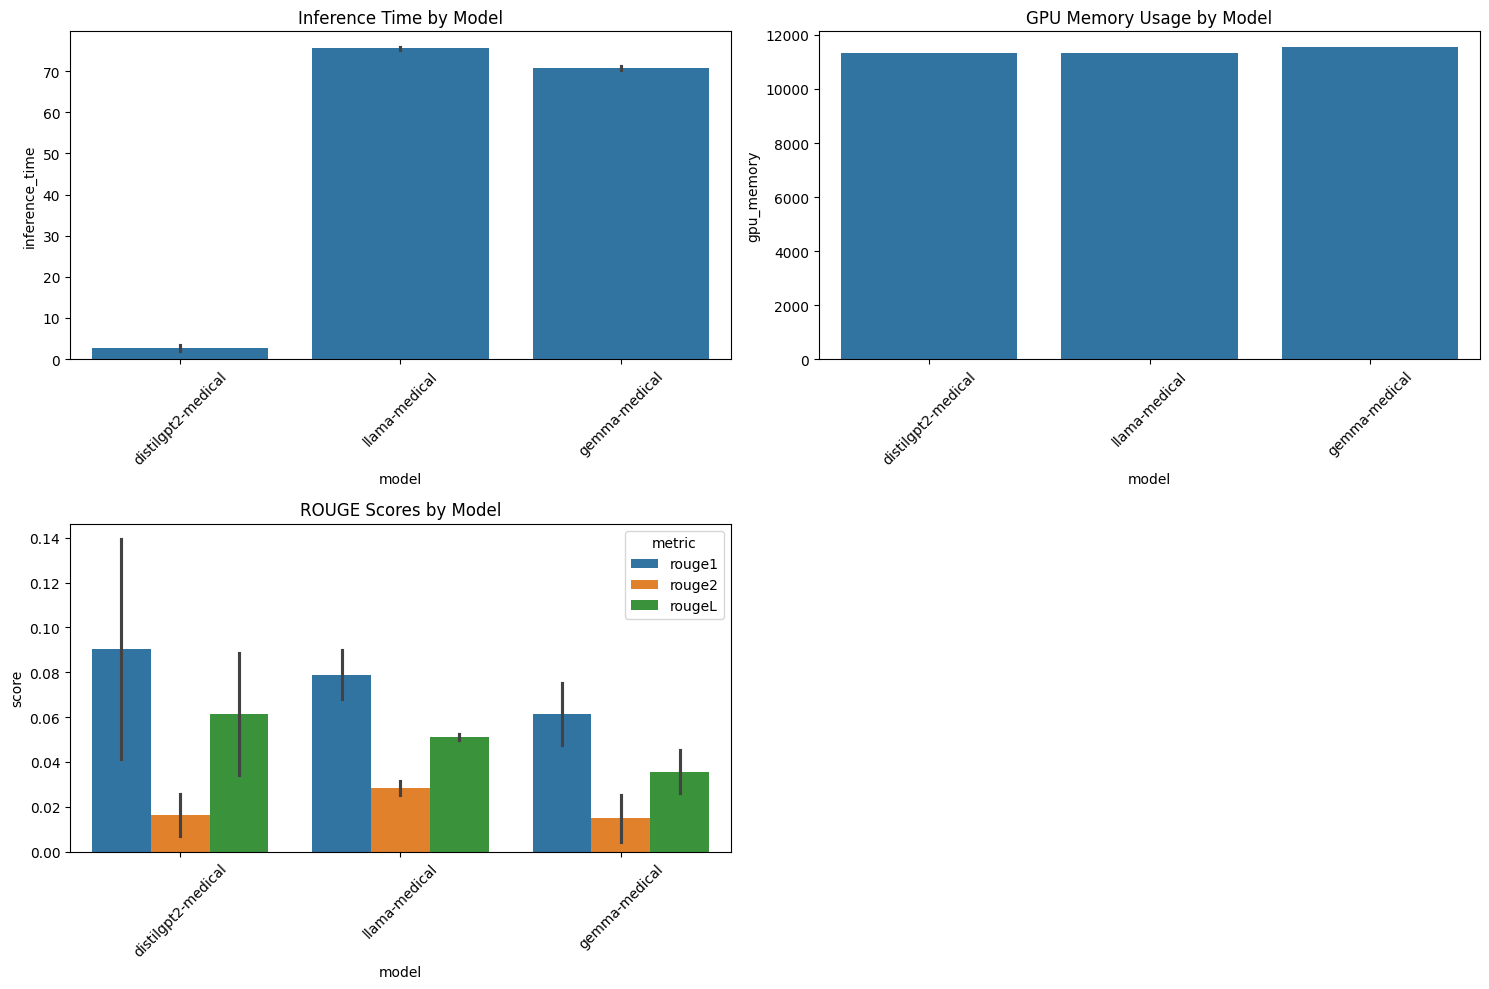


Evaluation complete!


In [22]:
class ModelManager:
    def __init__(self):
        self.models = {}
        self.bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )

    def load_model(self, model_name, model_path, use_quantization=False):
        try:
            print(f"\nLoading {model_name}...")
            gc.collect()
            torch.cuda.empty_cache()

            if use_quantization:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    quantization_config=self.bnb_config,
                    device_map="auto",
                    torch_dtype=torch.float16
                )
            else:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    torch_dtype=torch.float16
                ).to('cuda')

            tokenizer = AutoTokenizer.from_pretrained(model_path)
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token

            self.models[model_name] = (model, tokenizer)
            print(f"Successfully loaded {model_name}")
            return True

        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
            return False

    def evaluate_model(self, model_name, input_text, max_length=512):
        if model_name not in self.models:
            return None

        model, tokenizer = self.models[model_name]
        try:
            inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.95,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            inference_time = time.time() - start_time

            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

            return {
                'output': output_text,
                'inference_time': inference_time,
                'gpu_memory': gpu_memory
            }
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None

def evaluate_models():
    # Initialize scorer
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Test cases
    test_cases = [
        """
        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        """,
        """
        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
        """
    ]

    reference_answers = [
        """
        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        """,
        """
        Differential diagnosis includes:
        1. Pulmonary Embolism
        2. Pneumothorax
        3. Pleurisy
        4. Acute Coronary Syndrome

        Immediate workup needed:
        1. D-dimer
        2. Chest X-ray
        3. ECG
        4. Cardiac enzymes
        """
    ]

    # Initialize model manager
    manager = ModelManager()

    # Model configurations
    models_config = {
        'distilgpt2-medical': {
            'path': "Apurva3509/distilgpt2-medical-finetuned",
            'quantize': False
        },
        'llama-medical': {
            'path': "Apurva3509/llama-3-8b-Instruct-bnb-4bit-medical",
            'quantize': True
        },
        'gemma-medical': {
            'path': "Apurva3509/gemma-1.1-7b-it-bnb-4bit-medical",
            'quantize': True
        }
    }

    results = []

    # Load and evaluate each model
    for model_name, config in models_config.items():
        if manager.load_model(model_name, config['path'], config['quantize']):
            model_results = []

            for i, test_case in enumerate(test_cases):
                eval_result = manager.evaluate_model(model_name, test_case)

                if eval_result:
                    scores = scorer.score(reference_answers[i], eval_result['output'])

                    print(f"\n=== {model_name} Output for Case {i+1} ===")
                    print(f"Input:\n{test_case.strip()}")
                    print(f"\nGenerated Output:\n{eval_result['output']}")
                    print(f"\nReference Answer:\n{reference_answers[i]}")
                    print(f"\nMetrics:")
                    print(f"Inference Time: {eval_result['inference_time']:.2f}s")
                    print(f"GPU Memory: {eval_result['gpu_memory']:.1f}MB")
                    print(f"ROUGE-1: {scores['rouge1'].fmeasure:.3f}")
                    print(f"ROUGE-2: {scores['rouge2'].fmeasure:.3f}")
                    print(f"ROUGE-L: {scores['rougeL'].fmeasure:.3f}")
                    print("-" * 80)

                    model_results.append({
                        'model': model_name,
                        'case': i+1,
                        'inference_time': eval_result['inference_time'],
                        'gpu_memory': eval_result['gpu_memory'],
                        'rouge1': scores['rouge1'].fmeasure,
                        'rouge2': scores['rouge2'].fmeasure,
                        'rougeL': scores['rougeL'].fmeasure
                    })

            results.extend(model_results)

            # Clear memory after each model
            gc.collect()
            torch.cuda.empty_cache()

    return pd.DataFrame(results)

def plot_results(results_df):
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.barplot(data=results_df, x='model', y='inference_time')
    plt.title('Inference Time by Model')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 2)
    sns.barplot(data=results_df, x='model', y='gpu_memory')
    plt.title('GPU Memory Usage by Model')
    plt.xticks(rotation=45)

    plt.subplot(2, 2, 3)
    rouge_data = results_df.melt(
        id_vars=['model'],
        value_vars=['rouge1', 'rouge2', 'rougeL'],
        var_name='metric',
        value_name='score'
    )
    sns.barplot(data=rouge_data, x='model', y='score', hue='metric')
    plt.title('ROUGE Scores by Model')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    print("Starting model evaluation...")
    results_df = evaluate_models()
    print("\nPlotting results...")
    plot_results(results_df)
    print("\nEvaluation complete!")

# Evaluating all models with Bert and Bleu values

In [6]:
!pip install bert-score>=0.3.10

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import time
import numpy as np
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
import bert_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/amp10162/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Starting model evaluation...

Loading distilgpt2-medical...


/home/amp10162/.local/lib/python3.9/site-packages/peft/tuners/lora/layer.py:1150: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


Successfully loaded distilgpt2-medical


/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi


=== distilgpt2-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
          Answer on Dr. Paul Grouser's blog (http://www...

Reference Answer:

        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        

Metrics:
rouge1_f: 0.141
rouge2_f: 0.058
rougeL_f: 0.113
bleu: 0.000
bert_precision: 0.864
bert_recall: 0.881
b

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== distilgpt2-medical Output for Case 2 ===
Input:
Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?

Generated Output:

        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
           The primary reason why there are no known clinical indications for mild to moderate and severe symptoms in patients who have had a chronic or recurrent condition (HEP). For example - if you were diagnosed as having at least one heart attack during your last five years I would say that it's not unusual enough because they're usually very hard on their shoulders but also tend towards them when compared well above normal levels...but often we see this phenomenon being 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== distilgpt2-medical Output for Case 3 ===
Input:
Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?

Generated Output:

        Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?
          Subject ID:

Reference Answer:

        Management plan:
        1. Adjust diabetes medications
        2. Check blood pressure and kidney function
        3. Review diet and exercise
        4. Screen for complications

        Immediate steps:
        1. HbA1c test
        2. Comprehensive metabolic panel
        3. Urine microalbumin
        4. Referral to diabetes educator
        

Metrics:
rouge1_f: 0.211


Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/home/amp10162/.local/lib/python3.9/site-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Successfully loaded llama-medical


/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi


=== llama-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
         Possible Differential Diagnosis for Chest X-Ray Findings in Chronic Cough (Bacterial Pneumonia):
    Lung parenchymal disease 
Disease Pathological Description CXR findings Associated symptoms/physical examination signs  
Pulmonary tuberculosis   A nodular infiltrate that progresses to fibrosis usually involves both lungs The most common radiographic presentation is a solitary pulmonary nodule or cavitating lung lesion; irregularly shaped masses may be se

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== llama-medical Output for Case 2 ===
Input:
Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?

Generated Output:

        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
         - Cardiac tamponade,
          Pleural effusion,

TREATMENT:

Medical therapy includes a combination of diuretics and vasodilators to reduce preload (aspirin or warfarine) which will improve cardiac output.

Surgical treatment involves surgical drainage for chronic cases where there are significant fluid accumulation in pleura that does not respond adequately on conservative management.


SURGICAL APPROACHES FOR CHRONIC PLEURAL EFFUSION :

1. Thoracostomy : The most common

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== llama-medical Output for Case 3 ===
Input:
Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?

Generated Output:

        Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?
         Options for management of DM type II include pharmacological therapy as well lifestyle changes like diet modification or exercise to reduce blood glucose levels.

Answer the question truthfully based on your medical knowledge rather than providing any external link http://www.ncbi.nlm.nih.gov/books/NBK27900/ 
http:/ /en.wikipedia.org/wiki/Diabetes_mellitus_type_II  
Note that there is no direct relationship between fa

Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/home/amp10162/.local/lib/python3.9/site-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Successfully loaded gemma-medical


/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/amp10162/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi


=== gemma-medical Output for Case 1 ===
Input:
Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?

Generated Output:

        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
 >379		    ->  Pneumoconiosis (e g silicosis) or pneumothorax   ( e .g air embolism )model The following information should also help you decide on further investigations:


t', ->m =>sub("Home", "/home"), sub ("Education Resources","../educationresourcesnd }\z} if name == "." then exit() else return false fi }}):end END OF FILE *.*// /* *.htm page starts here */ #region main body region $w:<meta http_equiv='Content Type" content=='text html'; charset==iso _utf --

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== gemma-medical Output for Case 2 ===
Input:
Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?

Generated Output:

        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
> There appears no significant association between color doppler flow grade III/IV & culture positive results according To this study from Cleveland Clinic  and Mayo clinic   (Abstract number abstract ID #645780)cular ultrasound findings associated WITH cardiac infections:c ulcer Gastroesophagitis Hashimoto's thyroidism Hypertrophic cardiomyopathy Ischemic heart attack Inappropriate sinus rhythm Mitral stenosis Murphys sign Palpable precordial thrill Paroxysmal supraventricular ect

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== gemma-medical Output for Case 3 ===
Input:
Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?

Generated Output:

        Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?
 * An ACE inhibitor should also prevent renal damage caused by microalbuminuria / protein uria on chronic use so that it becomes an essential part every year up until age ~age >~ mid sixties unless there has already begun deterioration .model Although many different types exist they all aim towards improving glycaemic management without compromising safety through maintaining adequate fluid balance preventing intravascular vol

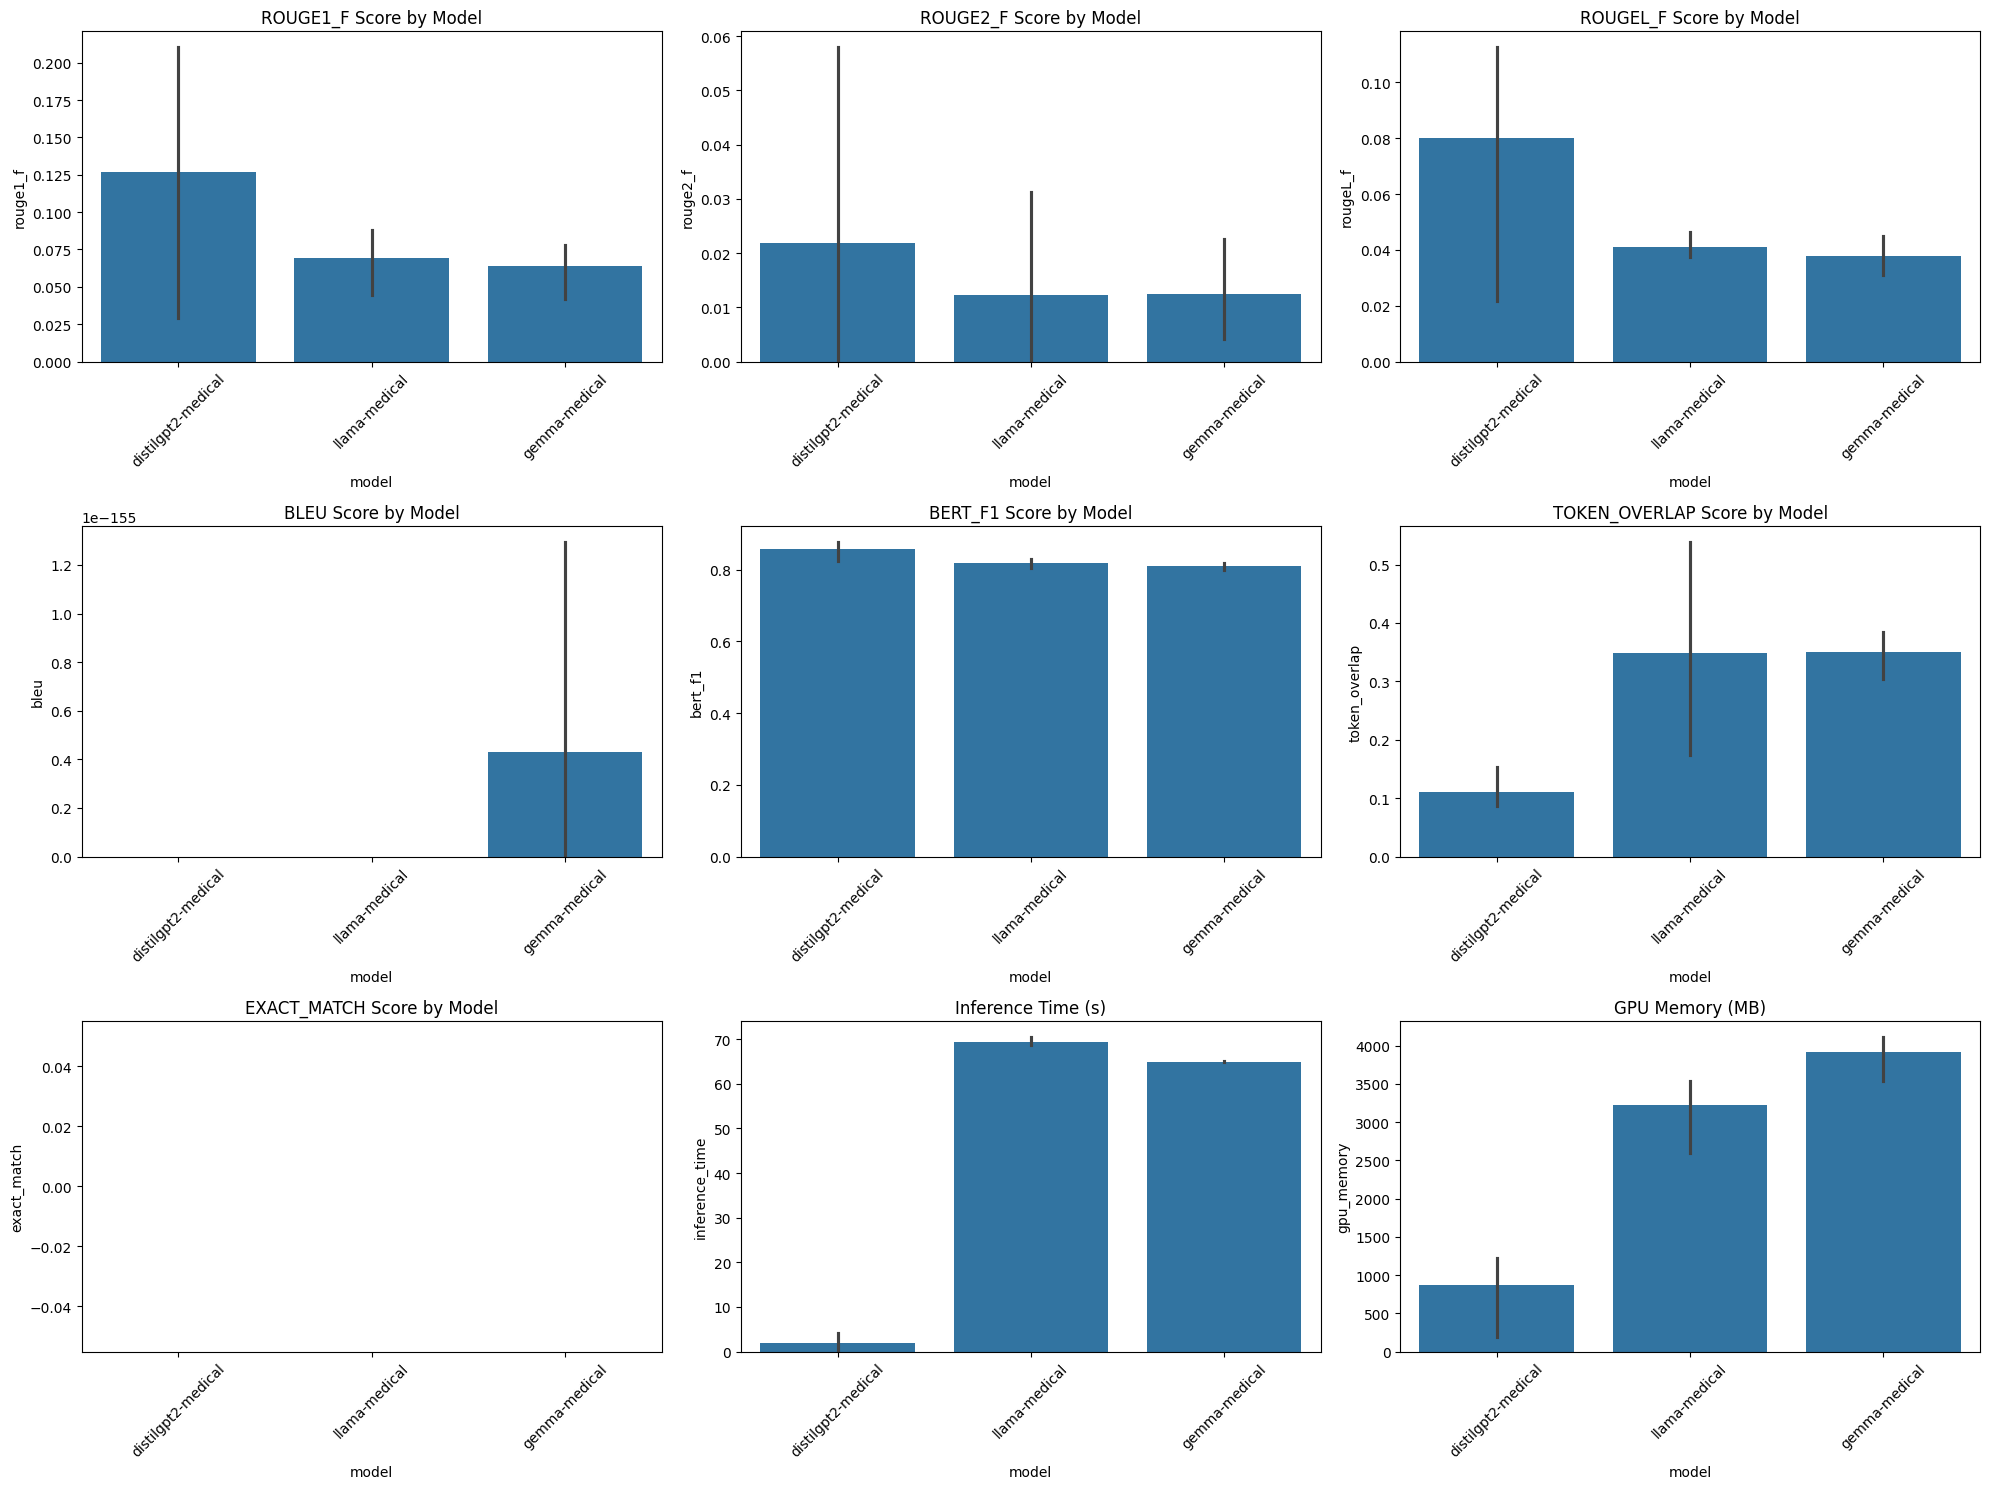


Generating summary statistics...

=== Summary Statistics ===
                   rouge1_f        rouge2_f        rougeL_f        bleu      bert_f1        token_overlap        exact_match      inference_time        gpu_memory         
                       mean    std     mean    std     mean    std mean  std    mean    std          mean    std        mean  std           mean    std       mean      std
model                                                                                                                                                                      
distilgpt2-medical    0.127  0.092    0.022  0.032    0.080  0.050  0.0  0.0   0.858  0.029         0.111  0.038         0.0  0.0          1.863  2.133    872.209  589.524
gemma-medical         0.064  0.020    0.012  0.009    0.038  0.007  0.0  0.0   0.811  0.010         0.351  0.042         0.0  0.0         64.983  0.126   3920.018  332.838
llama-medical         0.069  0.022    0.012  0.017    0.041  0.005  0.0  0.0  

In [8]:
class ModelManager:
    def __init__(self):
        self.models = {}
        self.bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.float16
        )
        self.rouge_scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    def load_model(self, model_name, model_path, use_quantization=False):
        try:
            print(f"\nLoading {model_name}...")
            gc.collect()
            torch.cuda.empty_cache()

            if use_quantization:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    quantization_config=self.bnb_config,
                    device_map="auto",
                    torch_dtype=torch.float16
                )
            else:
                model = AutoModelForCausalLM.from_pretrained(
                    model_path,
                    torch_dtype=torch.float16
                ).to('cuda')

            tokenizer = AutoTokenizer.from_pretrained(model_path)
            if tokenizer.pad_token is None:
                tokenizer.pad_token = tokenizer.eos_token

            self.models[model_name] = (model, tokenizer)
            print(f"Successfully loaded {model_name}")
            return True

        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
            return False

    def calculate_metrics(self, reference, prediction):
        try:
            # ROUGE scores
            rouge_scores = self.rouge_scorer.score(reference, prediction)

            # BLEU score
            reference_tokens = [reference.split()]
            prediction_tokens = prediction.split()
            bleu = sentence_bleu(reference_tokens, prediction_tokens)

            # BERTScore
            P, R, F1 = bert_score.score([prediction], [reference], lang='en', verbose=False)

            # Exact Match
            exact_match = 1.0 if prediction.strip() == reference.strip() else 0.0

            # Token overlap (custom metric)
            ref_tokens = set(reference.lower().split())
            pred_tokens = set(prediction.lower().split())
            token_overlap = len(ref_tokens.intersection(pred_tokens)) / len(ref_tokens)

            return {
                'rouge1_f': rouge_scores['rouge1'].fmeasure,
                'rouge2_f': rouge_scores['rouge2'].fmeasure,
                'rougeL_f': rouge_scores['rougeL'].fmeasure,
                'bleu': bleu,
                'bert_precision': P.item(),
                'bert_recall': R.item(),
                'bert_f1': F1.item(),
                'exact_match': exact_match,
                'token_overlap': token_overlap
            }
        except Exception as e:
            print(f"Error calculating metrics: {str(e)}")
            return None

    def evaluate_model(self, model_name, input_text, max_length=512):
        if model_name not in self.models:
            return None

        model, tokenizer = self.models[model_name]
        try:
            inputs = tokenizer([input_text], return_tensors="pt").to("cuda")

            start_time = time.time()
            with torch.no_grad():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=max_length,
                    do_sample=True,
                    temperature=0.7,
                    top_p=0.95,
                    repetition_penalty=1.5,
                    no_repeat_ngram_size=3,
                    pad_token_id=tokenizer.pad_token_id,
                    eos_token_id=tokenizer.eos_token_id
                )
            inference_time = time.time() - start_time

            output_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            gpu_memory = torch.cuda.max_memory_allocated() / 1024**2

            return {
                'output': output_text,
                'inference_time': inference_time,
                'gpu_memory': gpu_memory
            }
        except Exception as e:
            print(f"Error evaluating {model_name}: {str(e)}")
            return None

def evaluate_models():
    # Test cases
    test_cases = [
        """
        Patient Information:
        45-year-old male with persistent cough, weight loss, and night sweats.
        History of smoking 20 pack-years. No fever reported.
        Question: What are the potential diagnoses and next steps?
        """,
        """
        Patient Information:
        32-year-old female with sudden onset chest pain, shortness of breath.
        No prior medical history. Pain worse with deep breathing.
        Question: What is the differential diagnosis?
        """,
        """
        Patient Information:
        58-year-old diabetic patient with increasing thirst, frequent urination, and blurred vision.
        Blood sugar reading: 285 mg/dL. Last HbA1c (3 months ago): 7.2%
        Question: How would you manage this patient?
        """
    ]

    reference_answers = [
        """
        Potential diagnoses include:
        1. Pulmonary Tuberculosis
        2. Lung Cancer
        3. Chronic Bronchitis

        Next steps:
        1. Chest X-ray
        2. Sputum culture
        3. CBC with differential
        4. Quantiferon TB Gold test
        """,
        """
        Differential diagnosis includes:
        1. Pulmonary Embolism
        2. Pneumothorax
        3. Pleurisy
        4. Acute Coronary Syndrome

        Immediate workup needed:
        1. D-dimer
        2. Chest X-ray
        3. ECG
        4. Cardiac enzymes
        """,
        """
        Management plan:
        1. Adjust diabetes medications
        2. Check blood pressure and kidney function
        3. Review diet and exercise
        4. Screen for complications

        Immediate steps:
        1. HbA1c test
        2. Comprehensive metabolic panel
        3. Urine microalbumin
        4. Referral to diabetes educator
        """
    ]

    manager = ModelManager()

    models_config = {
        'distilgpt2-medical': {
            'path': "Apurva3509/distilgpt2-medical-finetuned",
            'quantize': False
        },
        'llama-medical': {
            'path': "Apurva3509/llama-3-8b-Instruct-bnb-4bit-medical",
            'quantize': True
        },
        'gemma-medical': {
            'path': "Apurva3509/gemma-1.1-7b-it-bnb-4bit-medical",
            'quantize': True
        }
    }

    results = []

    for model_name, config in models_config.items():
        if manager.load_model(model_name, config['path'], config['quantize']):
            model_results = []

            for i, test_case in enumerate(test_cases):
                eval_result = manager.evaluate_model(model_name, test_case)

                if eval_result:
                    metrics = manager.calculate_metrics(reference_answers[i], eval_result['output'])

                    if metrics:
                        result_dict = {
                            'model': model_name,
                            'case': i+1,
                            'inference_time': eval_result['inference_time'],
                            'gpu_memory': eval_result['gpu_memory'],
                            **metrics
                        }

                        model_results.append(result_dict)

                        print(f"\n=== {model_name} Output for Case {i+1} ===")
                        print(f"Input:\n{test_case.strip()}")
                        print(f"\nGenerated Output:\n{eval_result['output']}")
                        print(f"\nReference Answer:\n{reference_answers[i]}")
                        print(f"\nMetrics:")
                        for metric, value in metrics.items():
                            print(f"{metric}: {value:.3f}")
                        print(f"Inference Time: {eval_result['inference_time']:.2f}s")
                        print(f"GPU Memory: {eval_result['gpu_memory']:.1f}MB")
                        print("-" * 80)

            results.extend(model_results)

            gc.collect()
            torch.cuda.empty_cache()

    return pd.DataFrame(results)

def plot_results(results_df):
    metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f', 'bleu', 'bert_f1',
               'token_overlap', 'exact_match']

    n_metrics = len(metrics)
    n_cols = 3
    n_rows = (n_metrics + n_cols - 1) // n_cols

    plt.figure(figsize=(20, 5*n_rows))

    for i, metric in enumerate(metrics, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.barplot(data=results_df, x='model', y=metric)
        plt.title(f'{metric.upper()} Score by Model')
        plt.xticks(rotation=45)

    plt.subplot(n_rows, n_cols, n_metrics + 1)
    sns.barplot(data=results_df, x='model', y='inference_time')
    plt.title('Inference Time (s)')
    plt.xticks(rotation=45)

    plt.subplot(n_rows, n_cols, n_metrics + 2)
    sns.barplot(data=results_df, x='model', y='gpu_memory')
    plt.title('GPU Memory (MB)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def print_summary_statistics(results_df):
    print("\n=== Summary Statistics ===")
    metrics = ['rouge1_f', 'rouge2_f', 'rougeL_f', 'bleu', 'bert_f1',
               'token_overlap', 'exact_match', 'inference_time', 'gpu_memory']

    summary = results_df.groupby('model')[metrics].agg(['mean', 'std']).round(3)
    print(summary.to_string())

    print("\n=== Best Performing Models ===")
    for metric in metrics:
        best_model = results_df.loc[results_df[metric].idxmax()]
        print(f"{metric}: {best_model['model']} ({best_model[metric]:.3f})")

if __name__ == "__main__":

    print("Starting model evaluation...")
    results_df = evaluate_models()

    print("\nPlotting results...")
    plot_results(results_df)

    print("\nGenerating summary statistics...")
    print_summary_statistics(results_df)

    print("\nEvaluation complete!")